In [10]:
%matplotlib widget
from util import get_path
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from extract_graph import generate_nx_graph, transform_list, generate_skeleton, generate_nx_graph_from_skeleton, from_connection_tab, from_nx_to_tab
from node_id import whole_movement_identification, second_identification
import ast
from plotutil import plot_t_tp1, compress_skeleton
from scipy import sparse
from sparse_util import dilate, zhangSuen
from realign import realign
from datetime import datetime,timedelta
from node_id import orient
import pickle
from matplotlib.widgets import CheckButtons
import scipy.io as sio
import imageio
from pymatreader import read_mat
from matplotlib import colors
from copy import deepcopy,copy
from collections import Counter
import cv2 
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage.morphology import thin
from skimage import data, filters
from random import choice
import scipy.sparse
import os
from time import time
from skimage.feature import hessian_matrix_det
import sys
from extract_graph import dic_to_sparse, from_sparse_to_graph, generate_nx_graph, prune_graph, from_nx_to_tab, from_nx_to_tab_matlab,sparse_to_doc, connections_pixel_list_to_tab, transform_list, clean_degree_4
from sparse_util import dilate, zhangSuen


i = 15
plate = 3
directory = "/scratch/shared/mrozemul/Fiji.app/" 
listdir=os.listdir(directory) 
list_dir_interest=[name for name in listdir if name.split('_')[-1]==f'Plate{0 if plate<10 else ""}{plate}']
ss=[name.split('_')[0] for name in list_dir_interest]
ff=[name.split('_')[1] for name in list_dir_interest]
dates_datetime=[datetime(year=int(ss[i][:4]),month=int(ss[i][4:6]),day=int(ss[i][6:8]),hour=int(ff[i][0:2]),minute=int(ff[i][2:4])) for i in range(len(list_dir_interest))]
dates_datetime.sort()
dates_datetime_chosen=dates_datetime
dates = [f'{0 if date.month<10 else ""}{date.month}{0 if date.day<10 else ""}{date.day}_{0 if date.hour<10 else ""}{date.hour}{0 if date.minute<10 else ""}{date.minute}' for date in dates_datetime_chosen]
date =dates [i]
directory_name=f'2020{date}_Plate{0 if plate<10 else ""}{plate}'
path_snap='/scratch/shared/mrozemul/Fiji.app/'+directory_name
path_tile=path_snap+'/Img/TileConfiguration.txt.registered'
try:
    tileconfig = pd.read_table(path_tile,sep=';',skiprows=4,header=None,converters={2 : ast.literal_eval},skipinitialspace=True)
except:
    print('error_name')
    path_tile=path_snap+'/Img/TileConfiguration.registered.txt'
    tileconfig = pd.read_table(path_tile,sep=';',skiprows=4,header=None,converters={2 : ast.literal_eval},skipinitialspace=True)
dirName = path_snap+'/Analysis'
shape = (3000,4096)
try:
    os.mkdir(path_snap+'/Analysis') 
    print("Directory " , dirName ,  " Created ")
except FileExistsError:
    print("Directory " , dirName ,  " already exists")  
t=time()
xs =[c[0] for c in tileconfig[2]]
ys =[c[1] for c in tileconfig[2]]
dim = (int(np.max(ys)-np.min(ys))+4096,int(np.max(xs)-np.min(xs))+4096)
ims = []
for name in tileconfig[0]:
#     ims.append(imageio.imread('//sun.amolf.nl/shimizu-data/home-folder/oyartegalvez/Drive_AMFtopology/PRINCE'+date_plate+plate_str+'/Img/'+name))
    ims.append(imageio.imread(f'{name}'))
mask = np.zeros(dim,dtype=np.uint8)
for index,im in enumerate(ims):
    im_cropped = im
    im_blurred =cv2.blur(im_cropped, (100, 100))
    boundaries = int(tileconfig[2][index][0]-np.min(xs)),int(tileconfig[2][index][1]-np.min(ys))
    mask[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]] += im_blurred>70


          

Directory  /scratch/shared/mrozemul/Fiji.app/20200816_1257_Plate03/Analysis  already exists


In [13]:
skel_info = read_mat(path_snap+'/Analysis/skeleton.mat')
skel = skel_info['skeleton']


In [14]:
skel

<23719x43841 sparse matrix of type '<class 'numpy.uint8'>'
	with 1421955 stored elements in Compressed Sparse Column format>

In [11]:
masker = mask>0
kernel = np.ones((100,100),np.uint8)
output = 1-cv2.dilate(1-masker.astype(np.uint8),kernel,iterations = 1)

In [15]:
result = output*np.array(skel.todense())

In [16]:
sparse_result = scipy.sparse.csc_matrix(result)

In [17]:
mask_compressed= cv2.resize(output,(dim[1]//5,dim[0]//5))

In [3]:
sio.savemat(path_snap+'/Analysis/mask.mat',{'mask' : mask_compressed})

In [18]:
skel_compressed = cv2.resize(result,(dim[1]//5,dim[0]//5))

In [19]:
plt.close('all')
plot_t_tp1([],[],None,None,mask_compressed>0,skel_compressed)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [58]:
plt.close('all')
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(skel_compressed)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
plt.close('all')
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
mask = 1-(mask_compressed>0)
kernel = np.ones((50,50),np.uint8)
output = cv2.dilate(mask.astype(np.uint8),kernel,iterations = 1)
ax.imshow(output)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [121]:
plt.close('all')
for index,im in enumerate(ims[37:38]):
    print(index)
    im_cropped = im
    im_blurred =cv2.blur(im_cropped, (100, 100))
#     im_back_rem = (im_cropped+1)/(im_blurred+1)*120
#     frangised = frangi(im_back_rem,sigmas=range(5,20,4))*255
    
# #         meijered = meijering(im_back_rem,sigmas=range(1,10,4))*255
#     # # frangised = cv2.normalize(frangised, None, 0, 255, cv2.NORM_MINMAX)
#     hessian = abs(hessian_matrix_det(im_back_rem,sigma = 20, approximate=True,))
#     borders = np.zeros(hessian.shape)
#     width =100
#     borders[0:width,:]=1
#     borders[-width:,:]=1
#     borders[:,0:width]=1
#     borders[:,-width:]=1
#     hessian = cv2.blur(hessian, (20, 20))*(1-borders)
# #         transformed = (frangised+cv2.normalize(hessian, None, 0, 255, cv2.NORM_MINMAX)/4-im_back_rem+120)*(im_blurred>=35)
#     transformed = (frangised-im_back_rem+120)*(im_blurred>=35)
    fig=plt.figure(figsize=(10,9))
    ax = fig.add_subplot(111)
    ax.imshow(im_blurred)
#     ax.imshow(transformed)

0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [122]:
plt.close('all')
for index,im in enumerate(ims[65:67]):
    print(index)
    im_cropped = im
    im_blurred =cv2.blur(im_cropped, (100, 100))
#     im_back_rem = (im_cropped+1)/(im_blurred+1)*120
#     frangised = frangi(im_back_rem,sigmas=range(5,20,4))*255
    
# #         meijered = meijering(im_back_rem,sigmas=range(1,10,4))*255
#     # # frangised = cv2.normalize(frangised, None, 0, 255, cv2.NORM_MINMAX)
#     hessian = abs(hessian_matrix_det(im_back_rem,sigma = 20, approximate=True,))
#     borders = np.zeros(hessian.shape)
#     width =100
#     borders[0:width,:]=1
#     borders[-width:,:]=1
#     borders[:,0:width]=1
#     borders[:,-width:]=1
#     hessian = cv2.blur(hessian, (20, 20))*(1-borders)
# #         transformed = (frangised+cv2.normalize(hessian, None, 0, 255, cv2.NORM_MINMAX)/4-im_back_rem+120)*(im_blurred>=35)
#     transformed = (frangised-im_back_rem+120)*(im_blurred>=35)
    fig=plt.figure(figsize=(10,9))
    ax = fig.add_subplot(111)
    ax.imshow(im_blurred)
#     ax.imshow(transformed)

0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [93]:
# im_blurred2 =cv2.blur(transformed, (200, 200))
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(im_blurred2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [91]:
plt.close('all')
for index,im in enumerate(ims[65:67]):
    print(index)
    im_cropped = im
    im_blurred =cv2.blur(im_cropped, (200, 200))
    im_back_rem = (im_cropped+1)/(im_blurred+1)*120
    frangised = frangi(im_back_rem,sigmas=range(5,20,4))*255
    
#         meijered = meijering(im_back_rem,sigmas=range(1,10,4))*255
    # # frangised = cv2.normalize(frangised, None, 0, 255, cv2.NORM_MINMAX)
    hessian = abs(hessian_matrix_det(im_back_rem,sigma = 20, approximate=True,))
    borders = np.zeros(hessian.shape)
    width =100
    borders[0:width,:]=1
    borders[-width:,:]=1
    borders[:,0:width]=1
    borders[:,-width:]=1
    hessian = cv2.blur(hessian, (20, 20))*(1-borders)
#         transformed = (frangised+cv2.normalize(hessian, None, 0, 255, cv2.NORM_MINMAX)/4-im_back_rem+120)*(im_blurred>=35)
    transformed = (frangised-im_back_rem+120)*(im_blurred>=35)
    fig=plt.figure(figsize=(10,9))
    ax = fig.add_subplot(111)
    ax.imshow(im_blurred)
    ax.imshow(transformed)

0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

1


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [92]:
im_blurred3 =cv2.blur(transformed, (200, 200))
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(im_blurred3)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [23]:
%matplotlib widget
from util import get_path
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from extract_graph import generate_nx_graph, transform_list, generate_skeleton, generate_nx_graph_from_skeleton, from_connection_tab, from_nx_to_tab
from node_id import whole_movement_identification, second_identification
import ast
from plotutil import plot_t_tp1, compress_skeleton
from scipy import sparse
from sparse_util import dilate, zhangSuen
from realign import realign
from datetime import datetime,timedelta
from node_id import orient
import pickle
from matplotlib.widgets import CheckButtons
import scipy.io as sio
import imageio
from pymatreader import read_mat
from matplotlib import colors
from copy import deepcopy,copy
from collections import Counter
import cv2 
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage.morphology import thin
from skimage import data, filters
from random import choice
import scipy.sparse

In [2]:
from time import time,sleep
t=time()
sleep(5)
print('time=',time()-t)

time= 5.005275726318359


In [24]:
date = '0701_1557'
date_plate = f'/2020{date}'
plate = 13
plate_str = f'_Plate{plate}'
path_tile='//sun.amolf.nl/shimizu-data/home-folder/oyartegalvez/Drive_AMFtopology/PRINCE'+date_plate+plate_str+'/Img/TileConfiguration.registered.txt'
tileconfig = pd.read_table(path_tile,sep=';',skiprows=4,header=None,converters={2 : ast.literal_eval},skipinitialspace=True)
ims = []
for name in tileconfig[0]:
#     ims.append(imageio.imread('//sun.amolf.nl/shimizu-data/home-folder/oyartegalvez/Drive_AMFtopology/PRINCE'+date_plate+plate_str+'/Img/'+name))
    ims.append(np.load(f'Temp\{name}.npy'))

In [17]:
skel = np.zeros(dim,dtype=np.uint8)
shape = (3000,4096)
for index,im in enumerate(ims):
    sparse_dilated = scipy.sparse.load_npz(f'Temp/sparse_matrix{tileconfig[0][index][:-4]}.npz').todense()
    boundaries = int(tileconfig[2][index][0]-np.min(xs)),int(tileconfig[2][index][1]-np.min(ys))
#     print(boundaries)
#     print(skel[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]].shape,sparse_dilated.shape)
    skel[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]] += sparse_dilated

In [18]:
skel=np.array(255-255*(skel>0),dtype=np.uint8)

In [21]:
np.sum(skel>0),np.sum(skel<=0)

(551466781, 758094965)

In [30]:
import scipy.sparse
skel = np.zeros(dim,dtype=bool)
for index,im in enumerate(ims):
    im_cropped = im
    im_blurred =cv2.blur(im_cropped, (200, 200))
    im_back_rem = (im_cropped+1)/(im_blurred+1)
    im_back_rem = cv2.normalize(im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    im_back_rem_inv = cv2.normalize(255-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
#     frangised = frangi(im_back_rem,sigmas=range(1,20,4))
#     frangised = cv2.normalize(frangised, None, 0, 255, cv2.NORM_MINMAX)
#     transformed = cv2.normalize(frangised-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    transformed = cv2.normalize(-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
    low = 180
    high = 200
    lowt = (transformed > low).astype(int)
    hight = (transformed > high).astype(int)
    hyst = filters.apply_hysteresis_threshold(transformed, low, high)
    kernel = np.ones((3,3),np.uint8)
    dilation = cv2.dilate(hyst.astype(np.uint8) * 255,kernel,iterations = 1)
    for i in range(3):
        dilation=cv2.erode(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
        dilation = cv2.dilate(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
    dilated = dilation>0
    sparse_dilated = scipy.sparse.csc_matrix(dilated)
#     np.save(f'Temp\dilated{tileconfig[0][i]}',dilated)
    boundaries = int(tileconfig[2][index][0]-np.min(xs)),int(tileconfig[2][index][1]-np.min(ys))
#     print(boundaries)
#     print(skel[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]].shape,sparse_dilated.shape)
    if np.mean(sparse_dilated)<=0.5:
        skel[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]] += sparse_dilated
#     skeletonized = thin(dilated)
#     break

In [31]:
np.sum(skel>0)

13091473

In [32]:
np.sum(skel<=0)

1296470273

In [ ]:
skeletonized = cv2.ximgproc.thinning(np.array(255*(skel[10000:20000,10000:20000]>0),dtype=np.uint8))

In [28]:
plt.close('all')
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(skel[0:10000,10000:20000])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [3]:
xs =[c[0] for c in tileconfig[2]]
ys =[c[1] for c in tileconfig[2]]

In [4]:
dim = (int(np.max(ys)-np.min(ys))+4096,int(np.max(xs)-np.min(xs))+4096)

In [5]:
skel = np.zeros(dim,dtype=bool)

In [6]:
shape = (3000,4096)
for index,im in enumerate(ims):
    sparse_dilated = scipy.sparse.load_npz(f'Temp/sparse_matrix{tileconfig[0][index][:-4]}.npz').todense()
    boundaries = int(tileconfig[2][index][0]-np.min(xs)),int(tileconfig[2][index][1]-np.min(ys))
#     print(boundaries)
#     print(skel[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]].shape,sparse_dilated.shape)
    skel[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]] += sparse_dilated

In [8]:
im = choice(ims)
im_cropped = im
im_blurred =cv2.blur(im_cropped, (200, 200))
im_back_rem = (im_cropped+1)/(im_blurred+1)
im_back_rem = cv2.normalize(im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
im_back_rem_inv = cv2.normalize(255-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
#     frangised = frangi(im_back_rem,sigmas=range(1,20,4))
#     frangised = cv2.normalize(frangised, None, 0, 255, cv2.NORM_MINMAX)
#     transformed = cv2.normalize(frangised-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
transformed = cv2.normalize(-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)

In [9]:
plt.close('all')
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(transformed)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [27]:
sys.getsizeof(skel)/(10**6)

1309.561858

In [ ]:
skeletonized = thin(skel)

In [111]:
scipy.sparse.save_npz(f'Temp/sparse_matrix{tileconfig[0][i]}.npz', sparse_dilated)


In [56]:
values = [np.mean(im) for im in ims]

In [57]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.hist(values)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([33.,  2.,  4.,  5.,  8.,  8., 10.,  7., 32., 41.]),
 array([  0.        ,  15.46855857,  30.93711714,  46.40567571,
         61.87423428,  77.34279285,  92.81135142, 108.27990999,
        123.74846855, 139.21702712, 154.68558569]),
 <BarContainer object of 10 artists>)

In [107]:
plt.close('all')
im = choice(ims)
print(np.mean(im))
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(im)

11.942084879557292


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
im_cropped = im
im_blurred =cv2.blur(im_cropped, (200, 200))
im_back_rem = (im_cropped+1)/(im_blurred+1)
im_back_rem = cv2.normalize(im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
im_back_rem_inv = cv2.normalize(255-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
frangised = frangi(im_back_rem,sigmas=range(1,20,4))
frangised = cv2.normalize(frangised, None, 0, 255, cv2.NORM_MINMAX)
transformed = cv2.normalize(frangised-im_back_rem, None, 0, 255, cv2.NORM_MINMAX)
low = 100
high = 200
lowt = (transformed > low).astype(int)
hight = (transformed > high).astype(int)
hyst = filters.apply_hysteresis_threshold(transformed, low, high)
kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(hyst.astype(np.uint8) * 255,kernel,iterations = 1)
for i in range(3):
    dilation=cv2.erode(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
    dilation = cv2.dilate(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
dilated = dilation>0
skeletonized = thin(dilated)

In [108]:
im_cropped = im
im_blurred =cv2.blur(im_cropped, (200, 200))
im_back_rem = (im_cropped+1)/(im_blurred+1)
im_back_rem = cv2.normalize(im_back_rem, None, 0, 255, cv2.NORM_MINMAX)

In [109]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(im_back_rem)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [55]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(skeletonized)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [1]:
%matplotlib widget
from util import get_path
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from extract_graph import generate_nx_graph, transform_list, generate_skeleton, generate_nx_graph_from_skeleton, from_connection_tab, from_nx_to_tab
from node_id import whole_movement_identification, second_identification
import ast
from plotutil import plot_t_tp1, compress_skeleton
from scipy import sparse
from sparse_util import dilate, zhangSuen
from realign import realign
from datetime import datetime,timedelta
from node_id import orient
import pickle
from matplotlib.widgets import CheckButtons
import scipy.io as sio
import imageio
from pymatreader import read_mat
from matplotlib import colors
from copy import deepcopy,copy
from collections import Counter
import cv2 
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage.morphology import thin
from skimage import data, filters
from random import choice
import scipy.sparse
import os
from time import time
from skimage.feature import hessian_matrix_det
import sys
from extract_graph import dic_to_sparse, from_sparse_to_graph, generate_nx_graph, prune_graph, from_nx_to_tab, from_nx_to_tab_matlab,sparse_to_doc, connections_pixel_list_to_tab, transform_list, clean_degree_4
from sparse_util import dilate, zhangSuen


In [22]:
dates_datetime_chosen=dates_datetime
dates_datetime_chosen[24],dates_datetime_chosen[25]

(datetime.datetime(2020, 7, 20, 5, 25), datetime.datetime(2020, 7, 20, 12, 20))

In [59]:
plate = 9
directory = "/scratch/shared/mrozemul/Fiji.app/" 
listdir=os.listdir(directory) 
list_dir_interest=[name for name in listdir if name.split('_')[-1]==f'Plate{0 if plate<10 else ""}{plate}']
ss=[name.split('_')[0] for name in list_dir_interest]
ff=[name.split('_')[1] for name in list_dir_interest]
dates_datetime=[datetime(year=int(ss[i][:4]),month=int(ss[i][4:6]),day=int(ss[i][6:8]),hour=int(ff[i][0:2]),minute=int(ff[i][2:4])) for i in range(len(list_dir_interest))]
dates_datetime.sort()
dates_datetime_chosen=dates_datetime[9:20]
dates = [f'{0 if date.month<10 else ""}{date.month}{0 if date.day<10 else ""}{date.day}_{0 if date.hour<10 else ""}{date.hour}{0 if date.minute<10 else ""}{date.minute}' for date in dates_datetime_chosen]
dilateds=[]
skels = []
skel_docs = []
graph_pos=[]
contours=[]
half_circles=[]
for date in dates:
    directory_name=f'2020{date}_Plate{0 if plate<10 else ""}{plate}'
    path_snap='/scratch/shared/mrozemul/Fiji.app/'+directory_name
    skel_info = read_mat(path_snap+'/Analysis/skeleton.mat')
    skel = skel_info['skeleton']
    contour = skel_info['contour']
    half_circle = skel_info['half_circle']
    skels.append(skel)
    skel_doc = sparse_to_doc(skel)
    skel_docs.append(skel_doc)
    contours.append(contour)
    half_circles.append(half_circle)

In [3]:
def find_circle(x,y):
    x_m = np.mean(x)
    y_m = np.mean(y)

    # calculation of the reduced coordinates
    u = x - x_m
    v = y - y_m

    # linear system defining the center (uc, vc) in reduced coordinates:
    #    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
    #    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
    Suv  = np.sum(u*v)
    Suu  = np.sum(u**2)
    Svv  = np.sum(v**2)
    Suuv = np.sum(u**2 * v)
    Suvv = np.sum(u * v**2)
    Suuu = np.sum(u**3)
    Svvv = np.sum(v**3)

    # Solving the linear system
    A = np.array([ [ Suu, Suv ], [Suv, Svv]])
    B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
    uc, vc = np.linalg.solve(A, B)

    xc_1 = x_m + uc
    yc_1 = y_m + vc

    # Calcul des distances au centre (xc_1, yc_1)
    Ri_1     = np.sqrt((x-xc_1)**2 + (y-yc_1)**2)
    R_1      = np.mean(Ri_1)
    residu_1 = np.sum((Ri_1-R_1)**2)
    return(R_1,xc_1,yc_1)

In [11]:
find_circle(*half_circles[2].nonzero())

(21958.296326947304, 22681.210945141072, 23907.54454197127)

In [83]:
X = np.array(contours[i].nonzero())
Y = np.array(contours[i+1].nonzero())
X=np.transpose(np.array([x for x in np.transpose(X) if np.linalg.norm(x-np.array([xc_12,yc_12]))<R_12-100 and x[0]>=xc_12-1000 and x[0]<=xc_12+1000]))
Y=np.transpose(np.array([x for x in np.transpose(Y) if np.linalg.norm(x-np.array([xc_13,yc_13]))<R_13-100 and x[0]>=xc_13-1000 and x[0]<=xc_13+1000]))

In [87]:
def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 

In [89]:
xs,ys = X[0,:],X[1,:]

In [104]:
xs

array([24155, 24155, 24155, ..., 25161, 25161, 25167], dtype=int32)

In [99]:
b,a=estimate_coef(xs,ys)

In [107]:
x0 = np.mean(xs)-1000

In [115]:
A12

(24055.55844942221, 274.6272854784148)

In [117]:
np.flip(A12)

array([  274.62728548, 24055.55844942])

In [121]:
plt.close('all')
i=6
R_12,xc_12,yc_12 = find_circle(*half_circles[i].nonzero())
R_13,xc_13,yc_13 = find_circle(*half_circles[i+1].nonzero())
X = np.array(contours[i].nonzero())
Y = np.array(contours[i+1].nonzero())
X=np.transpose(np.array([x for x in np.transpose(X) if np.linalg.norm(x-np.array([xc_12,yc_12]))<R_12-100 and x[0]>=xc_12-1000 and x[0]<=xc_12+1000]))
Y=np.transpose(np.array([x for x in np.transpose(Y) if np.linalg.norm(x-np.array([xc_13,yc_13]))<R_13-100 and x[0]>=xc_13-1000 and x[0]<=xc_13+1000]))
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(X[0,:],X[1,:])
ax.scatter(Y[0,:],Y[1,:])
p = Point(xc_12,yc_12)
c = p.buffer(R_12).boundary
xs,ys = X[0,:],X[1,:]
b,a=estimate_coef(xs,ys)
x0 = np.mean(xs)
x1 = int(x0 - 1000)
y1 = int(a*x1+b)
x2 = int(x0 + 1000)
y2 = int(a*x2+b)
ax.axline((x1,y1),(x2,y2))

l = LineString([(x1,y1), (x2, y2)])
inter = c.intersection(l)

A12=inter.geoms[0].coords[0]
B12 = inter.geoms[1].coords[0]
A12,B12 = np.flip(A12),np.flip(B12)
p = Point(xc_13,yc_13)
c = p.buffer(R_13).boundary
xs,ys = Y[0,:],Y[1,:]
b,a=estimate_coef(xs,ys)
x0 = np.mean(xs)
x1 = int(x0 - 1000)
y1 = int(a*x1+b)
x2 = int(x0 + 1000)
y2 = int(a*x2+b)
ax.axline((x1,y1),(x2,y2),color='red')

l = LineString([(x1,y1), (x2, y2)])
inter = c.intersection(l)

A13=inter.geoms[0].coords[0]
B13 = inter.geoms[1].coords[0]
A13,B13 = np.flip(A13),np.flip(B13)

listeA,listeB = [A12,B12,(yc_12,xc_12)],[A13,B13,(yc_13,xc_13)]
H=np.dot(np.transpose(np.array(listeA)-np.mean(listeA,axis=0)),np.array(listeB)-np.mean(listeB,axis=0))
U,S,V=np.linalg.svd(H)
R=np.dot(V,np.transpose(U))
if np.linalg.det(R)<0:
    R *= np.array([[1,-1],[1,-1]])
t=np.mean(listeB,axis=0)-np.dot(R,np.mean(listeA,axis=0))
X = np.array(contours[i].nonzero())
Y = np.array(contours[i+1].nonzero())
# X=np.transpose(np.array([x for x in np.transpose(X) if np.linalg.norm(x-np.array([xc_12,yc_12]))<R_12-500 and x[0]>=xc_12-5000]))
# Y=np.transpose(np.array([x for x in np.transpose(Y) if np.linalg.norm(x-np.array([xc_13,yc_13]))<R_13-500 and x[0]>=xc_13-5000]))

fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(X[0,:],X[1,:])
ax.scatter(Y[0,:],Y[1,:])
ax.scatter(np.transpose(np.array(listeA))[1,:],np.transpose(np.array(listeA))[0,:])
ax.scatter(np.transpose(np.array(listeB))[1,:],np.transpose(np.array(listeB))[0,:])
# theta=lines13[0][0,1]-lines12[0][0,1]

# # Rot_init = np.array([[ np.cos(theta), np.sin(theta)],[ -np.sin(theta),  np.cos(theta)]])
# # new_center = np.dot(Rot_init,np.array([xc_12,yc_12]))
# # t_init=np.array([ xc_13-new_center[0], yc_13-new_center[1]])
Rot_init = R
t_init=np.array((t[1],t[0]))
# t_init = t
# theta=0
print(Rot_init)
Xex = np.transpose(np.transpose(np.dot(Rot_init,X))+t_init)
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(Xex[0,:],Xex[1,:])
ax.scatter(Y[0,:],Y[1,:])
# theta=lines13[0][0,1]-lines12[0][0,1]
# theta=0
# Rot_init = np.array([[ np.cos(theta), -np.sin(theta)],[ np.sin(theta),  np.cos(theta)]])
# Xex = np.transpose(np.transpose(np.dot(Rot_init,X))+t_init)
# fig=plt.figure(figsize=(10,9))
# ax = fig.add_subplot(111)
# ax.scatter(Xex[0,:],Xex[1,:])
# ax.scatter(Y[0,:],Y[1,:])
X = np.insert(X, 2, values=0, axis=0) 
Y = np.insert(Y, 2, values=0, axis=0) 

print(X.shape,Y.shape)
vectorX = o3d.utility.Vector3dVector(np.transpose(X))
vectorY = o3d.utility.Vector3dVector(np.transpose(Y))
source = o3d.geometry.PointCloud(vectorX)
target = o3d.geometry.PointCloud(vectorY)
threshold = 200

trans_init = np.asarray([[Rot_init[0,0], Rot_init[0,1], 0, t_init[0]],
                         [Rot_init[1,0], Rot_init[1,1], 0, t_init[1]],
                         [0, 0, 1, 0], [0.0, 0.0, 0.0, 1.0]])

reg_p2p = o3d.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
Rfound = reg_p2p.transformation[0:2,0:2]
tfound = reg_p2p.transformation[0:2,3]
print(Rfound,tfound)
X,Y=X[0:2,:],Y[0:2,:]
Yrep=np.transpose(np.transpose(np.dot(Rfound,X))+tfound)
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(np.transpose(Yrep)[:,0],np.transpose(Yrep)[:,1])
ax.scatter(np.transpose(Y)[:,0],np.transpose(Y)[:,1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[[ 9.99999984e-01  1.81621222e-04]
 [-1.81621222e-04  9.99999984e-01]]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(3, 95420) (3, 95839)
registration::RegistrationResult with fitness=9.998638e-01, inlier_rmse=1.622588e+01, and correspondence_set size of 95407
Access transformation to get result.
[[ 9.99999975e-01 -2.21617010e-04]
 [ 2.21617010e-04  9.99999975e-01]] [-234.19502434  -15.28528775]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [61]:
plt.close('all')
X = np.array(contours[i].nonzero())
Y = np.array(contours[i+1].nonzero())
X=np.transpose(np.array([x for x in np.transpose(X) if np.linalg.norm(x-np.array([xc_12,yc_12]))<R_12-100 and x[0]>=xc_12-1000 and x[0]<=xc_12+1000]))
Y=np.transpose(np.array([x for x in np.transpose(Y) if np.linalg.norm(x-np.array([xc_13,yc_13]))<R_13-100 and x[0]>=xc_13-1000 and x[0]<=xc_13+1000]))
border12 = np.zeros(contours[i].shape,dtype=np.uint8)
for x in np.transpose(X):
    border12[x[0],x[1]]=1
border13 = np.zeros(contours[i+1].shape,dtype=np.uint8)
for x in np.transpose(Y):
    border13[x[0],x[1]]=1
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(X[0,:],X[1,:])
ax.scatter(Y[0,:],Y[1,:])
lines12 = cv2.HoughLines(border12,500,np.pi/180,5000)
for rho,theta in lines12[:1,0,:]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    ax.axline((y1,x1),(y2,x2))
#     cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
lines13 = cv2.HoughLines(border13,500,np.pi/180,5000)
for rho,theta in lines13[:1,0,:]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    ax.axline((y1,x1),(y2,x2),color='red')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [66]:
from shapely.geometry import LineString
from shapely.geometry import Point

p = Point(yc_12,xc_12)
c = p.buffer(R_12).boundary
for rho,theta in lines12[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 100000*(-b))
    y1 = int(y0 + 100000*(a))
    x2 = int(x0 - 100000*(-b))
    y2 = int(y0 - 100000*(a))
l = LineString([(x1,y1), (x2, y2)])
inter = c.intersection(l)

A12=inter.geoms[0].coords[0]
B12 = inter.geoms[1].coords[0]
p = Point(yc_13,xc_13)
c = p.buffer(R_13).boundary
for rho,theta in lines13[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 100000*(-b))
    y1 = int(y0 + 100000*(a))
    x2 = int(x0 - 100000*(-b))
    y2 = int(y0 - 100000*(a))
l = LineString([(x1,y1), (x2, y2)])
inter = c.intersection(l)

A13=inter.geoms[0].coords[0]
B13 = inter.geoms[1].coords[0]
listeA,listeB = [A12,B12,(yc_12,xc_12)],[A13,B13,(yc_13,xc_13)]
H=np.dot(np.transpose(np.array(listeA)-np.mean(listeA,axis=0)),np.array(listeB)-np.mean(listeB,axis=0))
U,S,V=np.linalg.svd(H)
R=np.dot(V,np.transpose(U))
if np.linalg.det(R)<0:
    R *= np.array([[1,-1],[1,-1]])
t=np.mean(listeB,axis=0)-np.dot(R,np.mean(listeA,axis=0))

In [45]:
np.linalg.norm(np.array((yc_12,xc_12))-A12),np.linalg.norm(np.array((yc_12,xc_12))-B12)

(21878.86390883651, 21871.48245270054)

In [67]:
R,t

(array([[ 1.00000000e+00, -2.83539931e-06],
        [ 2.83539931e-06,  1.00000000e+00]]),
 array([  1.93774309, 423.67234531]))

In [70]:

import open3d as o3d
plt.close('all')
X = np.array(contours[i].nonzero())
Y = np.array(contours[i+1].nonzero())
# X=np.transpose(np.array([x for x in np.transpose(X) if np.linalg.norm(x-np.array([xc_12,yc_12]))<R_12-500 and x[0]>=xc_12-5000]))
# Y=np.transpose(np.array([x for x in np.transpose(Y) if np.linalg.norm(x-np.array([xc_13,yc_13]))<R_13-500 and x[0]>=xc_13-5000]))

fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(X[0,:],X[1,:])
ax.scatter(Y[0,:],Y[1,:])
ax.scatter(np.transpose(np.array(listeA))[1,:],np.transpose(np.array(listeA))[0,:])
ax.scatter(np.transpose(np.array(listeB))[1,:],np.transpose(np.array(listeB))[0,:])
# theta=lines13[0][0,1]-lines12[0][0,1]

# # Rot_init = np.array([[ np.cos(theta), np.sin(theta)],[ -np.sin(theta),  np.cos(theta)]])
# # new_center = np.dot(Rot_init,np.array([xc_12,yc_12]))
# # t_init=np.array([ xc_13-new_center[0], yc_13-new_center[1]])
Rot_init = R
t_init=np.array((t[1],t[0]))
# t_init = t
# theta=0
print(Rot_init)
Xex = np.transpose(np.transpose(np.dot(Rot_init,X))+t_init)
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(Xex[0,:],Xex[1,:])
ax.scatter(Y[0,:],Y[1,:])
# theta=lines13[0][0,1]-lines12[0][0,1]
# theta=0
# Rot_init = np.array([[ np.cos(theta), -np.sin(theta)],[ np.sin(theta),  np.cos(theta)]])
# Xex = np.transpose(np.transpose(np.dot(Rot_init,X))+t_init)
# fig=plt.figure(figsize=(10,9))
# ax = fig.add_subplot(111)
# ax.scatter(Xex[0,:],Xex[1,:])
# ax.scatter(Y[0,:],Y[1,:])
X = np.insert(X, 2, values=0, axis=0) 
Y = np.insert(Y, 2, values=0, axis=0) 

print(X.shape,Y.shape)
vectorX = o3d.utility.Vector3dVector(np.transpose(X))
vectorY = o3d.utility.Vector3dVector(np.transpose(Y))
source = o3d.geometry.PointCloud(vectorX)
target = o3d.geometry.PointCloud(vectorY)
threshold = 200

trans_init = np.asarray([[Rot_init[0,0], Rot_init[0,1], 0, t_init[0]],
                         [Rot_init[1,0], Rot_init[1,1], 0, t_init[1]],
                         [0, 0, 1, 0], [0.0, 0.0, 0.0, 1.0]])

reg_p2p = o3d.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
Rfound = reg_p2p.transformation[0:2,0:2]
tfound = reg_p2p.transformation[0:2,3]
print(Rfound,tfound)
X,Y=X[0:2,:],Y[0:2,:]
Yrep=np.transpose(np.transpose(np.dot(Rfound,X))+tfound)
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(np.transpose(Yrep)[:,0],np.transpose(Yrep)[:,1])
ax.scatter(np.transpose(Y)[:,0],np.transpose(Y)[:,1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[[ 1.00000000e+00 -2.83539931e-06]
 [ 2.83539931e-06  1.00000000e+00]]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(3, 96518) (3, 95420)
registration::RegistrationResult with fitness=9.998549e-01, inlier_rmse=1.525358e+01, and correspondence_set size of 96504
Access transformation to get result.
[[ 9.99999913e-01  4.16546865e-04]
 [-4.16546865e-04  9.99999913e-01]] [200.98464458  24.74981011]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [263]:
plt.close('all')
X = np.array(contour12.nonzero())
Y = np.array(contour13.nonzero())
X=np.transpose(np.array([x for x in np.transpose(X) if np.linalg.norm(x-np.array([xc_12,yc_12]))<R_12-500 and x[0]>=xc_12-1000 and x[0]<=xc_12+1000]))
Y=np.transpose(np.array([x for x in np.transpose(Y) if np.linalg.norm(x-np.array([xc_13,yc_13]))<R_13-500 and x[0]>=xc_13-1000 and x[0]<=xc_13+1000]))
border12 = np.zeros(contour12.shape,dtype=np.uint8)
for x in np.transpose(X):
    border12[x[0],x[1]]=1
border13 = np.zeros(contour13.shape,dtype=np.uint8)
for x in np.transpose(Y):
    border13[x[0],x[1]]=1
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(X[0,:],X[1,:])
ax.scatter(Y[0,:],Y[1,:])
lines12 = cv2.HoughLines(border12,200,np.pi/180,5000)
for rho,theta in lines12[:1,0,:]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    ax.axline((y1,x1),(y2,x2))
#     cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
lines13 = cv2.HoughLines(border13,200,np.pi/180,5000)
for rho,theta in lines13[:1,0,:]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 10000*(-b))
    y1 = int(y0 + 10000*(a))
    x2 = int(x0 - 10000*(-b))
    y2 = int(y0 - 10000*(a))
    ax.axline((y1,x1),(y2,x2),color='red')
#     cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

# cv2.imwrite('houghlines3.jpg',img)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [258]:
contour12.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [252]:
list(np.transpose(X)[-1])

[23636, 44962]

In [253]:
border12[list(np.transpose(X)[-1])]

SyntaxError: invalid syntax (<ipython-input-253-44c2e49d52c5>, line 1)

In [239]:
for x in np.transpose(X):
    print(x)
    break

[21804  4031]


In [220]:
lines12

array([[[2.4125000e+04, 1.5707964e+00]],

       [[2.3625000e+04, 1.5882496e+00]],

       [[2.1975000e+04, 1.6231562e+00]],

       [[2.2625000e+04, 1.5882496e+00]],

       [[2.4875000e+04, 1.5707964e+00]],

       [[2.5075000e+04, 1.5358897e+00]]], dtype=float32)

In [149]:
theta = lines12[0][0,1]
rho = lines12[0][0,0]
a12 = -1/np.tan(theta)
b12 = rho/np.sin(theta)
a12,b12

(0.017455009955542805, 24503.732)

In [152]:
!pip install shapely

     |████████████████████████████████| 1.0 MB 13.2 MB/s eta 0:00:01


In [264]:
from shapely.geometry import LineString
from shapely.geometry import Point

p = Point(xc_12,yc_12)
c = p.buffer(R_12).boundary
for rho,theta in lines12[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 100000*(-b))
    y1 = int(y0 + 100000*(a))
    x2 = int(x0 - 100000*(-b))
    y2 = int(y0 - 100000*(a))
l = LineString([(x1,y1), (x2, y2)])
i = c.intersection(l)

A12=i.geoms[0].coords[0]
B12 = i.geoms[1].coords[0]

In [265]:
p = Point(xc_13,yc_13)
c = p.buffer(R_13).boundary
for rho,theta in lines13[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 100000*(-b))
    y1 = int(y0 + 100000*(a))
    x2 = int(x0 - 100000*(-b))
    y2 = int(y0 - 100000*(a))
l = LineString([(x1,y1), (x2, y2)])
i = c.intersection(l)

A13=i.geoms[0].coords[0]
B13 = i.geoms[1].coords[0]

In [267]:
A12,B12,A13,B13

((802.134591953749, 22616.884510728756),
 (44509.32873714838, 23379.693283922246),
 (2639.3748141469514, 24449.49935040293),
 (47310.35606712032, 25229.13271460559))

In [225]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(np.transpose(np.array(listeA))[0,:],np.transpose(np.array(listeA))[1,:])
ax.scatter(np.transpose(np.array(listeB))[0,:],np.transpose(np.array(listeB))[1,:])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [176]:
np.array(listeA),listeB

(array([[ 2814.8856582 , 24552.58840094],
        [47595.17216992, 25334.12553882],
        [25236.29461139, 22885.12034923]]),
 [(991.7912525238436, 20730.102691401513),
  (45743.44343470322, 23075.405199304238),
  (23216.95990126062, 24822.30668275114)])

In [173]:
np.mean(listeA,axis=0)

array([25205.02891406, 24943.35696988])

In [200]:
listeA,listeB = [A12,B12,(xc_12,yc_12)],[A13,B13,(xc_13,yc_13)]
H=np.dot(np.transpose(np.array(listeA)-np.mean(listeA,axis=0)),np.array(listeB)-np.mean(listeB,axis=0))
U,S,V=np.linalg.svd(H)
R=np.dot(V,np.transpose(U))
if np.linalg.det(R)<0:
    R *= np.array([[1,-1],[1,-1]])
t=np.mean(listeB,axis=0)-np.dot(R,np.mean(listeA,axis=0))

In [201]:
R,t

(array([[ 0.99939097,  0.03489528],
        [-0.03489528,  0.99939097]]), array([-2729.16031862,  -486.6663274 ]))

In [202]:
np.dot(R,A12)+t,A13

(array([  940.78049997, 23952.74268433]),
 (991.7912525238436, 20730.102691401513))

In [203]:
np.dot(R,B12)+t,B13

(array([45721.06662021, 23171.18311581]),
 (45743.44343470322, 23075.405199304238))

In [204]:
np.dot(R,(xc_12,yc_12))+t,(xc_13,yc_13)

(array([23290.34746831, 21503.88877332]),
 (23216.95990126062, 24822.30668275114))

In [179]:
np.mean(listeA,axis=0)

array([25215.45081317, 24257.27809633])

In [122]:
np.cos(lines12[0][0,1]-lines13[0][0,1]),np.sin(lines12[0][0,1]-lines13[0][0,1])

(0.99939084, -0.034899537)

In [142]:
lines12[0][0,0]

24500.0

In [143]:
t_init

array([-2802.64187569,  2831.86200672])

In [141]:
lines12[0][0,0]-lines13[0][0,0]

3850.0

In [38]:
plate = 9
directory = "/scratch/shared/mrozemul/Fiji.app/" 
listdir=os.listdir(directory) 
list_dir_interest=[name for name in listdir if name.split('_')[-1]==f'Plate{0 if plate<10 else ""}{plate}']
ss=[name.split('_')[0] for name in list_dir_interest]
ff=[name.split('_')[1] for name in list_dir_interest]
dates_datetime=[datetime(year=int(ss[i][:4]),month=int(ss[i][4:6]),day=int(ss[i][6:8]),hour=int(ff[i][0:2]),minute=int(ff[i][2:4])) for i in range(len(list_dir_interest))]
dates_datetime.sort()
dates_datetime_chosen=dates_datetime[12:14]
dates = [f'{0 if date.month<10 else ""}{date.month}{0 if date.day<10 else ""}{date.day}_{0 if date.hour<10 else ""}{date.hour}{0 if date.minute<10 else ""}{date.minute}' for date in dates_datetime_chosen]
dilateds=[]
skels = []
skel_docs = []
graph_pos=[]
contours=[]
half_circles=[]
for date in dates:
    directory_name=f'2020{date}_Plate{0 if plate<10 else ""}{plate}'
    path_snap='/scratch/shared/mrozemul/Fiji.app/'+directory_name
    skel_info = read_mat(path_snap+'/Analysis/skeleton.mat')
    skel = skel_info['skeleton']
#     contour = skel_info['contour']
#     half_circle = skel_info['half_circle']
    skels.append(skel)
    skel_doc = sparse_to_doc(skel)
    skel_docs.append(skel_doc)



In [ ]:
skeleton1,skeleton2 = skel_docs[0],skel_docs[1]

# t_init=np.array([1936,-2019])
# Rot_init= np.array([[ 0.99999938, -0.00111566],
#  [ 0.00111566,  0.99999938]])
# nx_graph1,pos1 = generate_nx_graph(from_sparse_to_graph(skeleton1))
# nx_graph2,pos2 = generate_nx_graph(from_sparse_to_graph(skeleton2))

In [130]:
Rot_init = np.array([[ 9.99999985e-01, -1.74141272e-04],[ 1.74141272e-04,  9.99999985e-01]])
Rot_init[0,1]

-0.000174141272

In [51]:
plt.close('all')
plot_t_tp1([],[],None,None,contour12[0:8000,25000:38000].todense(),contour13[0+1081:8000+1081,25000-2312:38000-2312].todense())


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [43]:
plt.close('all')
plot_t_tp1([],[],None,None,contour12[2312:8000,28000:35000].todense(),contour13[2312:8000,28000:35000].todense())


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [154]:
x_m = np.mean(x)
y_m = np.mean(y)

# calculation of the reduced coordinates
u = x - x_m
v = y - y_m

# linear system defining the center (uc, vc) in reduced coordinates:
#    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
#    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
Suv  = np.sum(u*v)
Suu  = np.sum(u**2)
Svv  = np.sum(v**2)
Suuv = np.sum(u**2 * v)
Suvv = np.sum(u * v**2)
Suuu = np.sum(u**3)
Svvv = np.sum(v**3)

# Solving the linear system
A = np.array([ [ Suu, Suv ], [Suv, Svv]])
B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
uc, vc = np.linalg.solve(A, B)

xc_1 = x_m + uc
yc_1 = y_m + vc

# Calcul des distances au centre (xc_1, yc_1)
Ri_1     = np.sqrt((x-xc_1)**2 + (y-yc_1)**2)
R_1      = np.mean(Ri_1)
residu_1 = np.sum((Ri_1-R_1)**2)

In [156]:
xc_1,yc_1, R_1

(19132.812873300543, 25965.719356081285, 18857.46056358615)

In [126]:
np.sum(laplacian>=5)

0

In [112]:
for x in range(ims12[2].shape[0]):
    for y in range(ims12[2].shape[1]):
        

In [102]:
X = np.random.randint(0,ims12[2].shape[0],1000)

In [103]:
transit = []
for x in X:
    if ims12[12][x,-1]<=4:
        for y in range (ims12[2].shape[1]):
            if ims12[12][x,y]>4:
                transit.append((x,y))
                break

In [107]:
ims12[12].shape

(3000, 4096)

In [69]:
blurred

array([[  1,   1,   1, ...,   1,   1,   1],
       [  1,   1,   1, ...,   1,   1,   1],
       [  1,   1,   1, ...,   1,   1,   1],
       ...,
       [110, 110, 110, ...,  89,  89,  89],
       [110, 110, 110, ...,  89,  89,  89],
       [110, 110, 110, ...,  89,  89,  89]], dtype=uint8)

In [65]:
plt.close('all')
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(cv2.blur(ims12[2], (200, 200)))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(cv2.blur(ims12[-1], (200, 200)))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

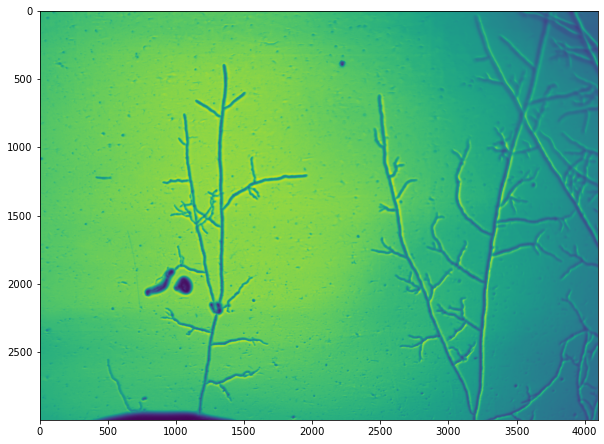

In [20]:
plt.close('all')
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.imshow(ims13[64])

In [1]:
%matplotlib widget
from util import get_path
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from extract_graph import generate_nx_graph, transform_list, generate_skeleton, generate_nx_graph_from_skeleton, from_connection_tab, from_nx_to_tab
from node_id import whole_movement_identification, second_identification
import ast
from plotutil import plot_t_tp1, compress_skeleton
from scipy import sparse
from sparse_util import dilate, zhangSuen
from realign import realign
from datetime import datetime,timedelta
from node_id import orient
import pickle
from matplotlib.widgets import CheckButtons
import scipy.io as sio
import imageio
from pymatreader import read_mat
from matplotlib import colors
from copy import deepcopy,copy
from collections import Counter
import cv2 
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage.morphology import thin
from skimage import data, filters
from random import choice
import scipy.sparse
import os
from time import time
from skimage.feature import hessian_matrix_det
import sys
from extract_graph import dic_to_sparse, from_sparse_to_graph, generate_nx_graph, prune_graph, from_nx_to_tab, from_nx_to_tab_matlab,sparse_to_doc, connections_pixel_list_to_tab, transform_list, clean_degree_4
from sparse_util import dilate, zhangSuen


i = 2
plate = 3
directory = "/scratch/shared/mrozemul/Fiji.app/" 
listdir=os.listdir(directory) 
list_dir_interest=[name for name in listdir if name.split('_')[-1]==f'Plate{0 if plate<10 else ""}{plate}']
ss=[name.split('_')[0] for name in list_dir_interest]
ff=[name.split('_')[1] for name in list_dir_interest]
dates_datetime=[datetime(year=int(ss[i][:4]),month=int(ss[i][4:6]),day=int(ss[i][6:8]),hour=int(ff[i][0:2]),minute=int(ff[i][2:4])) for i in range(len(list_dir_interest))]
dates_datetime.sort()
dates_datetime_chosen=dates_datetime
dates = [f'{0 if date.month<10 else ""}{date.month}{0 if date.day<10 else ""}{date.day}_{0 if date.hour<10 else ""}{date.hour}{0 if date.minute<10 else ""}{date.minute}' for date in dates_datetime_chosen]
date =dates [i]
directory_name=f'2020{date}_Plate{0 if plate<10 else ""}{plate}'
path_snap='/scratch/shared/mrozemul/Fiji.app/'+directory_name
path_tile=path_snap+'/Img/TileConfiguration.txt.registered'
try:
    tileconfig = pd.read_table(path_tile,sep=';',skiprows=4,header=None,converters={2 : ast.literal_eval},skipinitialspace=True)
except:
    print('error_name')
    path_tile=path_snap+'/Img/TileConfiguration.registered.txt'
    tileconfig = pd.read_table(path_tile,sep=';',skiprows=4,header=None,converters={2 : ast.literal_eval},skipinitialspace=True)
dirName = path_snap+'/Analysis'
shape = (3000,4096)
try:
    os.mkdir(path_snap+'/Analysis') 
    print("Directory " , dirName ,  " Created ")
except FileExistsError:
    print("Directory " , dirName ,  " already exists")  
t=time()
xs =[c[0] for c in tileconfig[2]]
ys =[c[1] for c in tileconfig[2]]
dim = (int(np.max(ys)-np.min(ys))+4096,int(np.max(xs)-np.min(xs))+4096)
ims = []
for name in tileconfig[0]:
#     ims.append(imageio.imread('//sun.amolf.nl/shimizu-data/home-folder/oyartegalvez/Drive_AMFtopology/PRINCE'+date_plate+plate_str+'/Img/'+name))
    ims.append(imageio.imread(f'{name}'))
mask = np.zeros(dim,dtype=np.uint8)
for index,im in enumerate(ims):
    im_cropped = im
    im_blurred =cv2.blur(im_cropped, (100, 100))
    boundaries = int(tileconfig[2][index][0]-np.min(xs)),int(tileconfig[2][index][1]-np.min(ys))
    mask[boundaries[1]:boundaries[1]+shape[0],boundaries[0]:boundaries[0]+shape[1]] += im_blurred>70
    
skel_info = read_mat(path_snap+'/Analysis/skeleton.mat')
skel = skel_info['skeleton']
masker = mask>0
kernel = np.ones((100,100),np.uint8)
output = 1-cv2.dilate(1-masker.astype(np.uint8),kernel,iterations = 1)
result = output*np.array(skel.todense())
sio.savemat(path_snap+'/Analysis/skeleton_masked.mat',{'skeleton' : scipy.sparse.csc_matrix(result)})

Directory  /scratch/shared/mrozemul/Fiji.app/20200814_0857_Plate03/Analysis  already exists
